In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers.experimental import preprocessing
# print(tf.__version__)

# Make numpy printouts easier to read.
np.set_printoptions(precision=3, suppress=True)

# raw_dataset = pd.read_csv("/data/fast0/datasets/glathida-3.1.0/data/T.csv")
raw_dataset = pd.read_csv("~/data/glac/TT.csv")
# raw_dataset = pd.read_csv("~/stuff/coding/glacier/data/T.csv")

dataset = raw_dataset.copy()

#examine data columns
dataset.head()

,GlaThiDa_ID,POLITICAL_UNIT,GLACIER_NAME,SURVEY_DATE,LOWER_BOUND,UPPER_BOUND,AREA,MEAN_SLOPE,MEAN_THICKNESS,MEAN_THICKNESS_UNCERTAINTY,MAXIMUM_THICKNESS,MAX_THICKNESS_UNCERTAINTY,DATA_FLAG,REMARKS
0,97,AT,GR. GOSAU,19689999,2250,2270,0.011,12.0,43,NaN,NaN,NaN,NaN,NaN
1,97,AT,GR. GOSAU,19689999,2270,2290,0.014,15.0,36,NaN,NaN,NaN,NaN,NaN
2,97,AT,GR. GOSAU,19689999,2290,2310,0.015,18.0,29,NaN,NaN,NaN,NaN,NaN
3,97,AT,GR. GOSAU,19689999,2310,2330,0.021,25.0,22,NaN,NaN,NaN,NaN,NaN
4,97,AT,GR. GOSAU,19689999,2330,2350,0.038,18.0,19,NaN,NaN,NaN,NaN,NaN


In [2]:
#drop everything but lat, long, elevation, thickness

dataset = dataset.drop("GlaThiDa_ID", axis=1)
dataset = dataset.drop("GLACIER_NAME", axis=1)
dataset = dataset.drop("SURVEY_DATE", axis=1)
dataset = dataset.drop("POLITICAL_UNIT", axis=1)
dataset = dataset.drop("MEAN_THICKNESS", axis=1)
dataset = dataset.drop("MEAN_THICKNESS_UNCERTAINTY", axis=1)
dataset = dataset.drop("MAX_THICKNESS_UNCERTAINTY", axis=1)
dataset = dataset.drop("DATA_FLAG", axis=1)
dataset = dataset.drop("REMARKS", axis=1)

#drop the remaining null pieces from elevation
dataset = dataset.dropna()
dataset.isna().sum()

LOWER_BOUND          0
UPPER_BOUND          0
AREA                 0
MEAN_SLOPE           0
MAXIMUM_THICKNESS    0
dtype: int64

In [3]:
dataset

,LOWER_BOUND,UPPER_BOUND,AREA,MEAN_SLOPE,MAXIMUM_THICKNESS
81,2600,2650,0.01985,24.0,29.0
82,2650,2700,0.03433,20.0,36.0
83,2700,2750,0.02145,23.0,23.0
84,2750,2800,0.00505,28.0,10.0
85,2540,2560,0.00660,4.0,10.0
...,...,...,...,...,...
406,4700,4800,0.47900,21.0,112.0
407,4800,4900,0.55900,23.0,91.0
408,4900,5000,0.54500,26.0,83.0
409,5000,5100,0.37900,24.0,36.0


# 

In [4]:
#split the dataset and reserve some to test what was trained.
train_dataset = dataset.sample(frac=0.8, random_state=0)
test_dataset = dataset.drop(train_dataset.index)

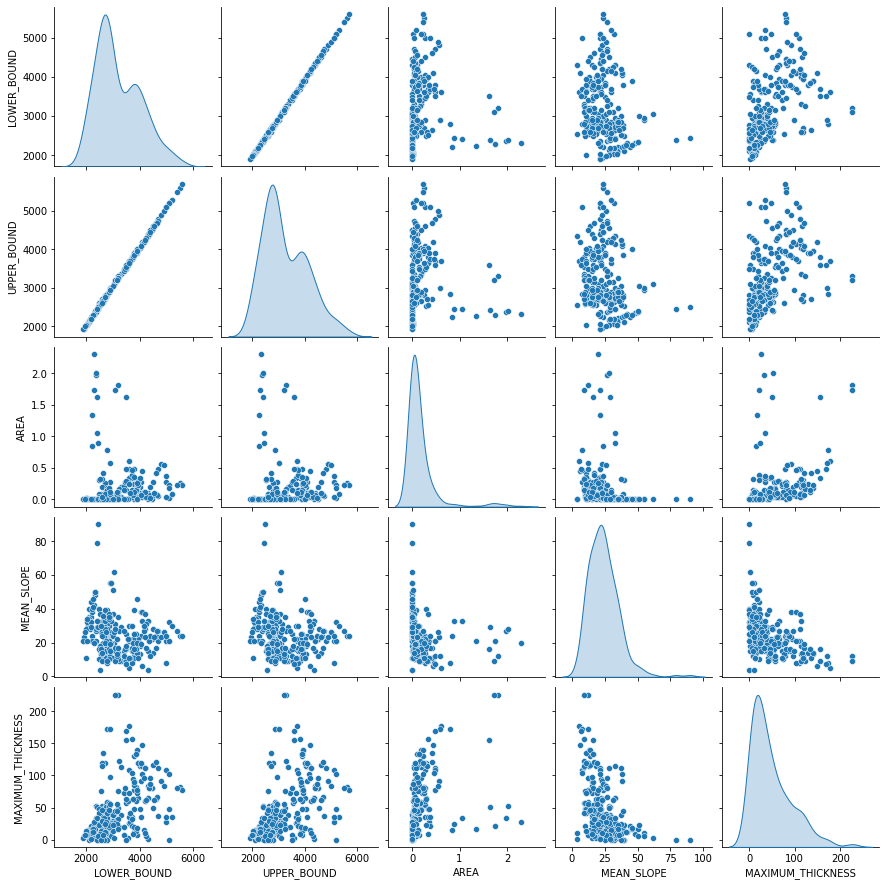

In [5]:
sns.pairplot(train_dataset[["LOWER_BOUND", "UPPER_BOUND", "AREA", "MEAN_SLOPE", "MAXIMUM_THICKNESS"]], diag_kind='kde')

In [6]:
train_dataset.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
LOWER_BOUND,252.0,3205.591270,825.956760,1900.00000,2600.00,2950.00000,3800.00000,5600.00000
UPPER_BOUND,252.0,3254.769841,841.514265,1920.00000,2650.00,3000.00000,3900.00000,5700.00000
AREA,252.0,0.173664,0.356148,0.00004,0.01,0.04984,0.17376,2.30146
MEAN_SLOPE,252.0,24.015873,11.599206,4.00000,15.00,22.00000,30.00000,90.00000
MAXIMUM_THICKNESS,252.0,48.206349,44.028209,0.00000,14.00,35.00000,73.00000,226.00000


In [7]:
#separate out features - what will be trained to predict desired attribute
train_features = train_dataset.copy()
test_features = test_dataset.copy()

#define label - attribute training to be picked
train_labels = train_features.pop("MAXIMUM_THICKNESS")
test_labels = test_features.pop("MAXIMUM_THICKNESS")

train_features.describe().transpose()[['mean', 'std']]

,mean,std
LOWER_BOUND,3205.591270,825.956760
UPPER_BOUND,3254.769841,841.514265
AREA,0.173664,0.356148
MEAN_SLOPE,24.015873,11.599206


# Establish normalization layers

In [8]:
normalizer = {}
variable_list = ("LOWER_BOUND", "UPPER_BOUND", "AREA", "MEAN_SLOPE")
for variable_name in variable_list:

    normalizer[variable_name] = preprocessing.Normalization(input_shape=[1,], axis=None)
    normalizer[variable_name].adapt(np.array(train_features[variable_name]))
    
    
normalizer['ALL'] = preprocessing.Normalization(axis=-1)
normalizer['ALL'].adapt(np.array(train_features))

# Single variable linear regression functions

In [9]:
def build_linear_model(normalizer):
    model = tf.keras.Sequential([
        normalizer,
        layers.Dense(1)
    ])

    model.compile(
        optimizer=tf.optimizers.Adam(learning_rate=0.1),
        loss="mean_absolute_error")
    
    return model

def plot_single_model_variable(x, y,feature_name):
    plt.scatter(train_features[feature_name], train_labels, label='Data')
    plt.plot(x, y, color='k', label='Predictions')
    plt.xlabel(feature_name)
    plt.ylabel("Avg Thickness (m)")
#     plt.xlim((0,20))
    plt.legend()
      
def plot_loss(history):
#     plt.subplots(figsize=(10,5))
    plt.plot(history.history['loss'], label='loss')
    plt.plot(history.history['val_loss'], label='val_loss')
    #   plt.ylim([0, 10])
    plt.xlabel('Epoch')
    plt.ylabel('Error')
    plt.legend()
    plt.grid(True)

# import glacierml as gl

In [10]:
test_results = {}
linear_model = {}
linear_history = {}
linear_results = {}

# Linear regression

In [11]:
%%time
variable_list = ("LOWER_BOUND", "UPPER_BOUND", "AREA", "MEAN_SLOPE")
for variable_name in variable_list:

    linear_model[variable_name] = build_linear_model(normalizer[variable_name])
    linear_history[variable_name] = linear_model[variable_name].fit(
                                        train_features[variable_name], train_labels,        
                                        epochs=1000,
                                        verbose=0,
                                        validation_split = 0.2)
    linear_results[variable_name] = linear_model[variable_name].evaluate(
                                        test_features[variable_name],
                                        test_labels, verbose=0)

linear_results

CPU times: user 2min 24s, sys: 1min 15s, total: 3min 39s
Wall time: 1min 58s


{'LOWER_BOUND': 33.873443603515625,
 'UPPER_BOUND': 33.74726867675781,
 'AREA': 38.51561737060547,
 'MEAN_SLOPE': 36.65205764770508}

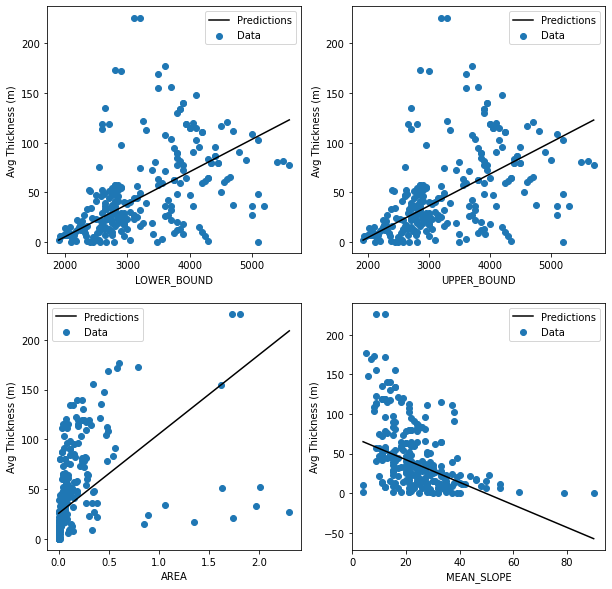

In [12]:
fig,ax=plt.subplots(2,2,figsize=(10,10))
for i, variable_name in enumerate(variable_list):
    plt.subplot(2,2,i+1)
    xmax = np.max(train_features[variable_name])
    xmin = np.min(train_features[variable_name])
    x = tf.linspace(xmin, xmax, 101)
    y = linear_model[variable_name].predict(x)
    plot_single_model_variable(x,y,variable_name)

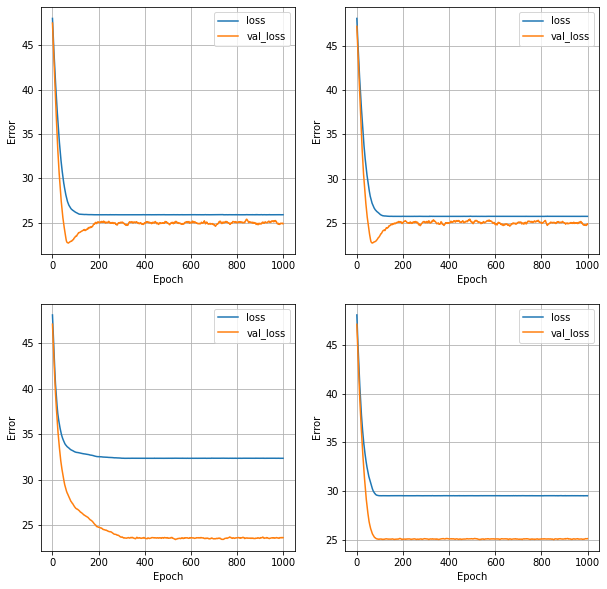

In [13]:
fig,ax=plt.subplots(2,2,figsize=(10,10))
for i, variable_name in enumerate(variable_list):
    plt.subplot(2,2,i+1)
    plot_loss(linear_history[variable_name])

# Linear regression with multiple inputs

In [14]:
linear_model = build_linear_model(normalizer['ALL'])

history = linear_model.fit(
train_features, train_labels,        
   epochs=1000,
   verbose=0,
   validation_split = 0.2)

test_results["MULTI"] = linear_model.evaluate(
    test_features,
    test_labels, verbose=0)

test_results

{'MULTI': 31.999155044555664}

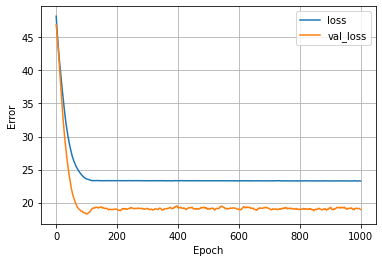

In [15]:
plot_loss(history)

# DNN regression

## Define regression functions

In [16]:
def build_dnn_model(norm):
    model = keras.Sequential([
              norm,
              layers.Dense(64, activation='relu'),
              layers.Dense(64, activation='relu'),
              layers.Dense(1) ])

    model.compile(loss='mean_absolute_error',
                optimizer=tf.keras.optimizers.Adam(0.001))
    
    return model

def dnn_test_results(feature_name):
    dnn_test_results[feature_name] = dnn_model.evaluate(
        test_features[feature_name],
        test_labels, verbose=0)

In [17]:
test_results = {}
dnn_model = {}
dnn_history = {}
dnn_results = {}

In [18]:
variable_list = ("LOWER_BOUND", "UPPER_BOUND", "AREA", "MEAN_SLOPE")
for variable_name in variable_list:

    dnn_model[variable_name] = build_dnn_model(normalizer[variable_name])
    dnn_history[variable_name] = dnn_model[variable_name].fit(
                                        train_features[variable_name], train_labels,        
                                        epochs=1000,
                                        verbose=0,
                                        validation_split = 0.2)
    dnn_results[variable_name] = dnn_model[variable_name].evaluate(
                                        test_features[variable_name],
                                        test_labels, verbose=0)

dnn_results

{'LOWER_BOUND': 33.1540412902832,
 'UPPER_BOUND': 33.2336311340332,
 'AREA': 29.980976104736328,
 'MEAN_SLOPE': 35.44021987915039}

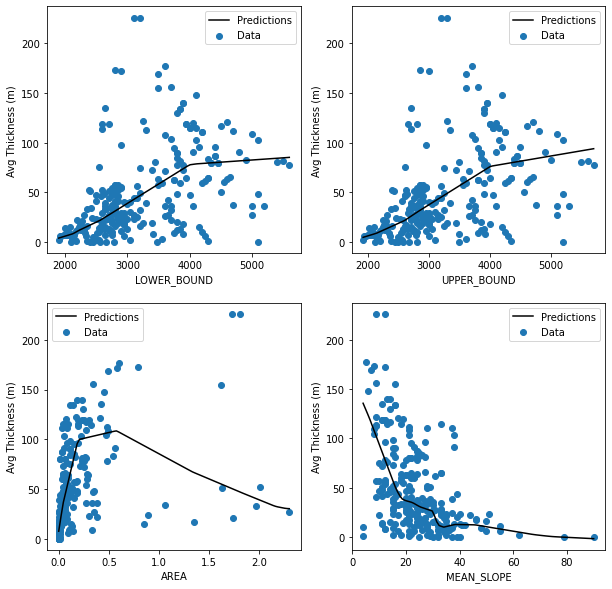

In [19]:
fig,ax=plt.subplots(2,2,figsize=(10,10))
for i, variable_name in enumerate(variable_list):
    plt.subplot(2,2,i+1)
    xmax = np.max(train_features[variable_name])
    xmin = np.min(train_features[variable_name])
    x = tf.linspace(xmin, xmax, 101)
    y = dnn_model[variable_name].predict(x)
    plot_single_model_variable(x,y,variable_name)

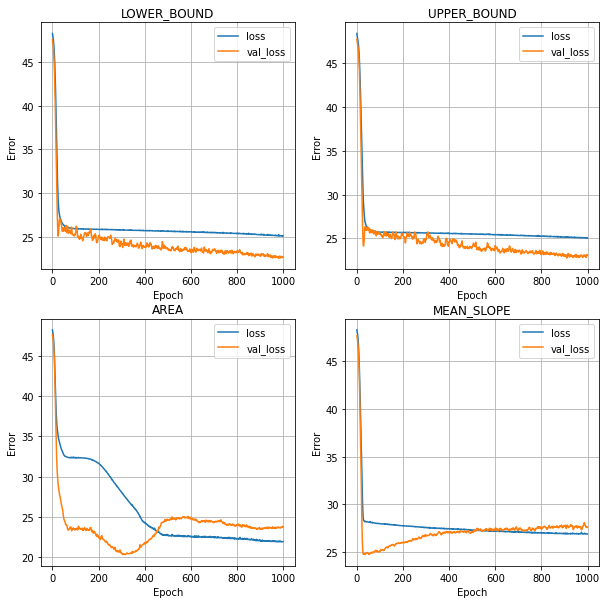

In [20]:
fig,ax=plt.subplots(2,2,figsize=(10,10))
for i, variable_name in enumerate(variable_list):
    ax=plt.subplot(2,2,i+1)
    plot_loss(dnn_history[variable_name])
    ax.set_title(variable_name)

# Full model

In [21]:
dnn_full_model = build_dnn_model(normalizer['ALL'])

In [22]:
%%time
history_full = dnn_full_model.fit(
    train_features, train_labels,
    validation_split=0.2,
    verbose=0, epochs=1000)

CPU times: user 54.3 s, sys: 23.9 s, total: 1min 18s
Wall time: 29.5 s


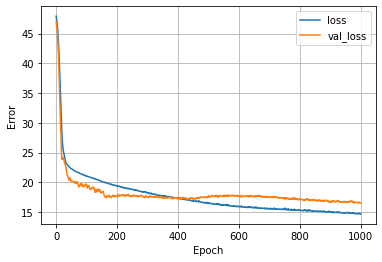

In [23]:
plot_loss(history_full)

In [24]:
test_results["dnn_full_model"] = dnn_full_model.evaluate(
    test_features,
    test_labels, verbose=0)

test_results

{'dnn_full_model': 21.17877960205078}

Text(0, 0.5, 'Model Area (km**2)')

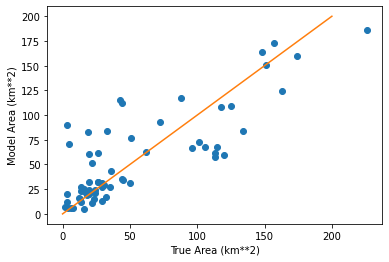

In [25]:
y = dnn_full_model.predict(test_features)
plt.plot(test_labels,y,'o')
plt.plot((0,200),(0,200),'-')
plt.xlabel('True Area (km**2)')
plt.ylabel('Model Area (km**2)')

Text(0, 0.5, 'Count')

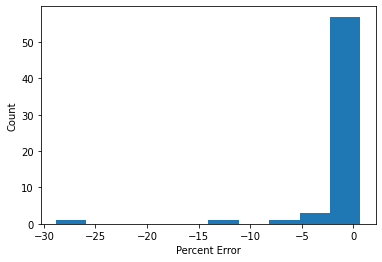

In [26]:
plt.subplots()
x = np.reshape(test_labels.values, (-1, 1)) # Training values in a n-by-1 array
pct_error = (x-y)/x
plt.hist(pct_error.flatten())
plt.xlabel('Percent Error')
plt.ylabel('Count')